In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random as rnd
from tqdm import tqdm

import torch
from torch import nn, optim, flatten, sigmoid
from torch.utils.data import TensorDataset, random_split, DataLoader
from torchsummary import summary

from google.colab import files

!git clone https://github.com/hsd1503/resnet1d.git

Cloning into 'resnet1d'...
remote: Enumerating objects: 238, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 238 (delta 64), reused 61 (delta 26), pack-reused 128
Receiving objects: 100% (238/238), 11.90 MiB | 9.82 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [2]:
from resnet1d.net1d import Net1D

In [3]:
if not torch.cuda.is_available():
  print("Set google colab runtime to GPU!")
else:
  device = "cuda"
  print("Using " + device)
  device = torch.device(device)

Using cuda


In [37]:
def load_model():
    model = Net1D(
        in_channels=1,
        base_filters=16,
        ratio=1.0,
        filter_list=[16, 32, 64, 128],
        m_blocks_list=[2, 2, 2, 2],
        kernel_size=3,
        stride=2,
        groups_width=1,
        n_classes=1,
        verbose=False,
        use_do = False,
        use_bn = True,
    )
    model.to(device)
    return model

In [8]:
def loadDataSet(filename):
    with open(filename, 'rb') as f:
        X, Y = pickle.load(f)
    return X, Y

def createDataset(X, Y, device="cpu", batch_size=32, test_split=0.1):
    # split to test / train
    n_data = len(X)
    n_test = int(test_split*n_data)
    n_train = n_data - n_test

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    dataSet = TensorDataset(X.float(), Y.float())

    train_dataset, test_dataset = random_split(dataSet, [n_train, n_test])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [35]:
batch_size = 32

X, Y = loadDataSet('data_w30_labeled_augmented.pickle')

train_loader, test_loader = createDataset(X, Y, device, batch_size, test_split=0.1)

In [38]:
learning_rate  = 0.001
epochs         = 50

network = load_model()

optimizer = optim.Adam(network.parameters(), lr=learning_rate)
loss_function = nn.MSELoss() #nn.HuberLoss()
losses = []
for epoch in range(epochs):
    loss = 0
    for x, y in train_loader:
        x = torch.unsqueeze(x, dim=1)
        optimizer.zero_grad() 
        y_pred = network(x)
        y_pred = torch.reshape(y_pred, y.size())
        train_loss = loss_function(y, y_pred)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss / len(train_loader)

    with torch.no_grad():
        test_loss = 0
        for x, y in test_loader:
            x = torch.unsqueeze(x, dim=1)
            y_pred = network(x)
            y_pred = torch.reshape(y_pred, y.size())
            test_loss += loss_function(y, y_pred).item()
        test_loss = test_loss / len(test_loader)

    losses.append((loss, test_loss))

    print("epoch : {}/{}, loss = {:.2f}, test loss = {:.2f}".format(epoch + 1, epochs, loss*100, test_loss*100)) 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch : 1/50, loss = 4.87, test loss = 2.56
epoch : 2/50, loss = 2.34, test loss = 1.67
epoch : 3/50, loss = 1.53, test loss = 1.23
epoch : 4/50, loss = 1.26, test loss = 1.06
epoch : 5/50, loss = 1.03, test loss = 0.94
epoch : 6/50, loss = 1.04, test loss = 0.99
epoch : 7/50, loss = 0.92, test loss = 0.82
epoch : 8/50, loss = 0.74, test loss = 0.72
epoch : 9/50, loss = 0.78, test loss = 0.67
epoch : 10/50, loss = 0.74, test loss = 0.66
epoch : 11/50, loss = 0.60, test loss = 0.67
epoch : 12/50, loss = 0.56, test loss = 0.55
epoch : 13/50, loss = 0.57, test loss = 0.67
epoch : 14/50, loss = 0.59, test loss = 0.49
epoch : 15/50, loss = 0.56, test loss = 0.57
epoch : 16/50, loss = 0.50, test loss = 0.44
epoch : 17/50, loss = 0.41, test loss = 0.47
epoch : 18/50, loss = 0.43, test loss = 0.38
epoch : 19/50, loss = 0.45, test loss = 0.50
epoch : 20/50, loss = 0.37, test loss = 0.33
epoch : 21/50, loss = 0.35, test loss = 0.34
epoch : 22/50, loss = 0.28, test loss = 0.28
epoch : 23/50, loss

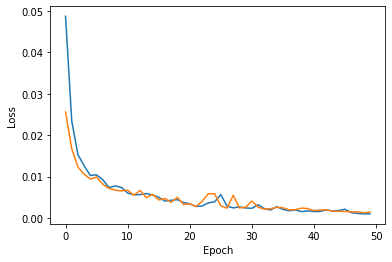

In [39]:
train_loss = [epoch[0] for epoch in losses]
test_loss = [epoch[1] for epoch in losses]

plt.plot(train_loss, label='Train loss')
plt.plot(test_loss, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


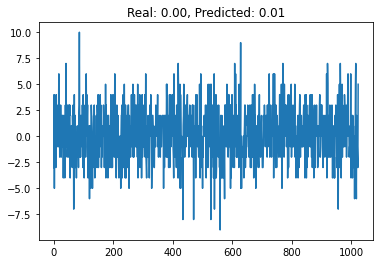

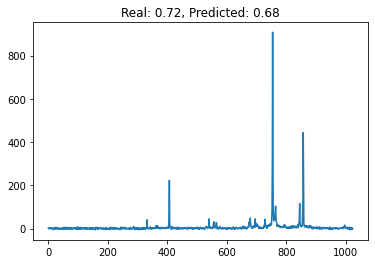

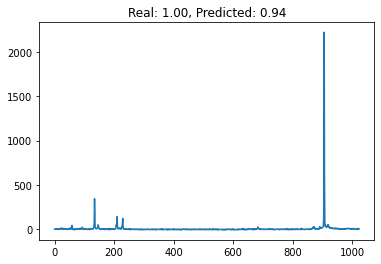

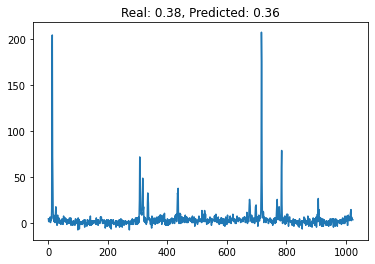

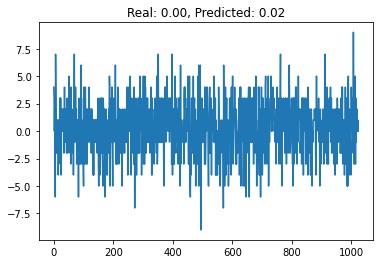

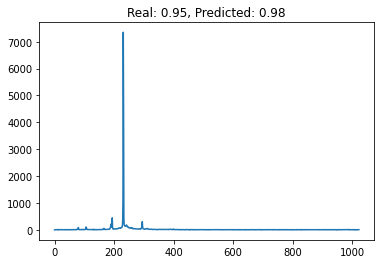

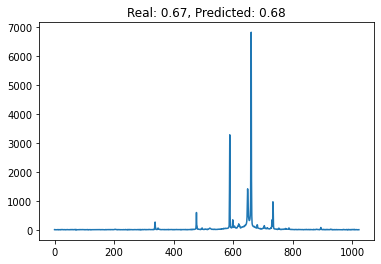

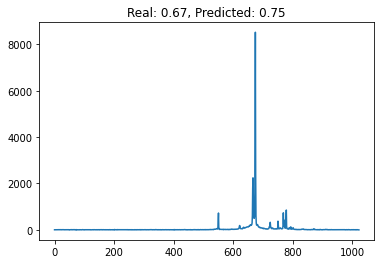

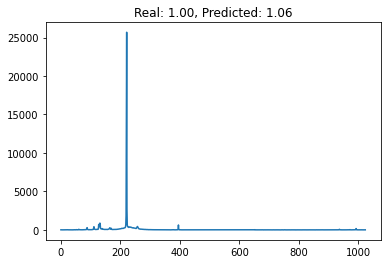

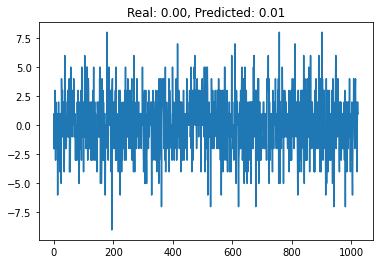

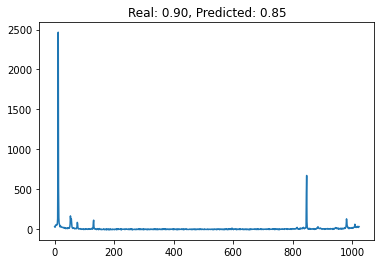

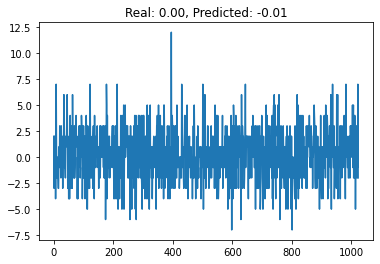

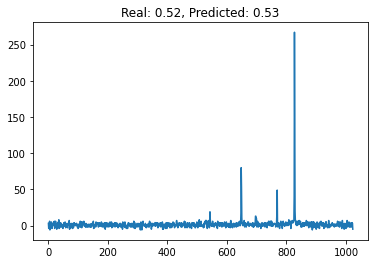

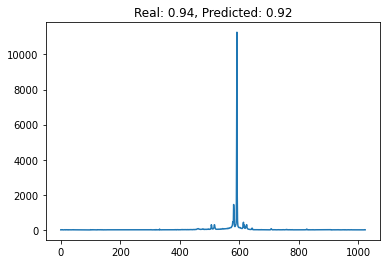

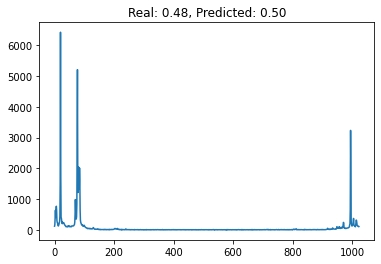

KeyboardInterrupt: ignored

In [41]:
for x_batch, y_batch in test_loader:
  x_batch = torch.unsqueeze(x_batch, dim=1)
  y_pred  = torch.squeeze(network(x_batch))
  x_batch = np.squeeze(x_batch.cpu().detach().numpy())
  y_batch = y_batch.cpu().detach().numpy()
  y_pred  = y_pred.cpu().detach().numpy()
  n_batch = x_batch.shape[0]
  for idx in range(n_batch):
    x   = x_batch[idx]
    y   = y_batch[idx]
    y_p = y_pred[idx]
    plt.plot(x)
    plt.title('Real: {:.2f}, Predicted: {:.2f}'.format(y, y_p))
    plt.show()